<a href="https://colab.research.google.com/github/wilwal23/google-colabs/blob/main/simple_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [23]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

training_data.data = training_data.data.view(-1, 784).float()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming you have training_data and test_data
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True, pin_memory=True)



In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [4]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        # Call the constructor of the parent class (nn.Module)
        super(Generator, self).__init__()

        # Define the first fully connected layer
        self.fc1 = nn.Linear(input_size, hidden_size)

        # Define the second fully connected layer
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Pass the input through the first fully connected layer
        x = torch.relu(self.fc1(x))

        # Pass the output through the second fully connected layer with tanh activation
        x = torch.tanh(self.fc2(x))

        # Return the final output
        return x

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        # Call the constructor of the parent class (nn.Module)
        super(Discriminator, self).__init__()

        # Define the first fully connected layer
        self.fc1 = nn.Linear(input_size, hidden_size)

        # Define the second fully connected layer
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Pass the input through the first fully connected layer with ReLU activation
        x = torch.relu(self.fc1(x))

        # Pass the output through the second fully connected layer with sigmoid activation
        x = torch.sigmoid(self.fc2(x))

        # Return the final output
        return x

In [27]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the input and output sizes for the generator and discriminator
input_size = 784  # Assuming input size for both generator and discriminator is the same
hidden_size = 256
output_size = 1

# Create instances of the Discriminator and Generator, and move them to the specified device
discriminator = Discriminator(input_size, hidden_size, output_size).to(device)
generator = Generator(input_size, hidden_size, output_size).to(device)

# Set the loss function (Binary Cross Entropy with Logits) for training the discriminator
loss_fn = nn.BCEWithLogitsLoss()

# Set the optimizers for the discriminator and generator

# Adam optimizer for the discriminator
# Parameters: discriminator.parameters() - All parameters of the discriminator
# Learning rate: lr=0.0002 - Rate at which the optimizer adjusts the model weights
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

# Adam optimizer for the generator
# Parameters: generator.parameters() - All parameters of the generator
# Learning rate: lr=0.0002 - Rate at which the optimizer adjusts the model weights
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)

torch.Size([60000, 784])
64


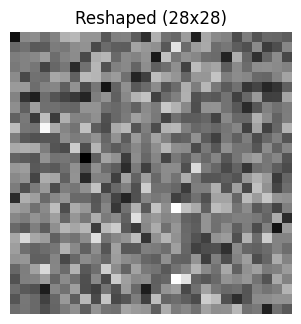

In [48]:
# Set the number of training epochs and the size of the noise vector used as input to the generator
num_epochs = 200
noise_size = 784

print(train_dataloader.dataset.data.size())
print(train_dataloader.batch_size)

batch_size = 64

noise = torch.randn(batch_size, noise_size).to(device)

reshaped_tensor = noise[0].view(28, 28)

# Convert tensors to numpy arrays
flattened_array = noise[0].numpy()
reshaped_array = reshaped_tensor.numpy()

# Plot the original and reshaped tensors
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 2)
plt.imshow(reshaped_array, cmap='gray')
plt.title('Reshaped (28x28)')
plt.axis('off')

plt.show()

In [46]:
# Set the number of training epochs and the size of the noise vector used as input to the generator
num_epochs = 200
noise_size = 784

# Training loop
for epoch in range(num_epochs):
    # Iterate over batches in the dataloader
    for i, (real_images, _) in enumerate(train_dataloader):
        # Get the batch size
        batch_size = real_images.size(0)
        # Generate fake images
        noise = torch.randn(batch_size, noise_size).to(device)
        fake_images = generator(noise)

        # Train the discriminator on real and fake images
        d_real = discriminator(real_images)
        d_fake = discriminator(fake_images)

        # Calculate the loss
        real_loss = loss_fn(d_real, torch.ones_like(d_real))
        fake_loss = loss_fn(d_fake, torch.zeros_like(d_fake))
        d_loss = real_loss + fake_loss

        # Backpropagate and optimize
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train the generator
        d_fake = discriminator(fake_images)
        g_loss = loss_fn(d_fake, torch.ones_like(d_fake))

        # Backpropagate and optimize
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Print the loss every 50 batches
        if (i+1) % 50 == 0:
          print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}'
                .format(epoch+1, num_epochs, i+1, len(train_dataloader), d_loss.item(), g_loss.item()))

torch.Size([64, 784])


RuntimeError: ignored